# Imaging Script Demo

In [1]:
%matplotlib notebook

from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.linalg import hadamard
import copy

In [2]:
noise_magnitude = 50
enable_noise = True

## Single-Pixel Imaging

In [3]:
# these functions could go in a helper.py file
def gen_noise_vec(noise_magnitude, height, width):
    sigma = noise_magnitude / np.sqrt(height * width) # noise magnitude --> std dev
    noise = np.abs(np.random.normal(0, sigma, height * width)).astype(int)
    return noise

def img_to_gray_matrix(path):
    img = np.array(Image.open(path).convert(mode = 'L'))
    height, width = get_img_dim(img)
    if enable_noise:
        img = np.add(img, np.reshape(gen_noise_vec(noise_magnitude, height, width), (height, width)))
    return img

def get_img_dim(img):
    return img.shape

def gen_identity_H(height, width):
    return np.eye(height * width)

def gen_random_H_single(height, width):
    dim = height * width
    blank_H = np.zeros((dim, dim))
    possible_idx = np.arange(0, height * width, 1)
    for i in range(dim):
        random_idx = np.random.choice(possible_idx)
        blank_H[i][random_idx] = 1
        possible_idx = np.delete(possible_idx, np.argwhere(possible_idx == random_idx))
    return blank_H

def gen_H_Alt(height, width):
    H = gen_identity_H(height, width)
    return np.vstack((H[::2], H[1::2]))

def intermediate_mask_results(height, width, H, img):
    mask_results = []
    nonzero_idx = []
    for mask in H:
        mask_matrix = np.reshape(mask, (height, width))
        curr_scan = np.array([np.array([img[r][c] if mask_matrix[r][c] == 1 else 0 for c in range(len(img[r]))]) for r in range(len(img))])
        rows, cols = np.nonzero(curr_scan)
        nonzero_idx.append(curr_scan[rows, cols])
        mask_results.append(curr_scan)
    return mask_results, nonzero_idx
    
def cumulative_mask_results(intermediate_results, incr_val = None):
    cumulative_results = []
    for r1_idx in range(len(intermediate_results)):
        curr_cum_img = np.zeros((height, width))
        for r2_idx in range(r1_idx + 1):
            curr_r2 = copy.deepcopy(intermediate_results[r2_idx])
            if incr_val:
                curr_r2[curr_r2 != 0] = incr_val
            curr_cum_img += curr_r2
        cumulative_results.append(curr_cum_img)
    return cumulative_results

def setup_graph():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    return fig, ax

def update_fn_factory(fig, ax, result_array):
    def slider_graph_update(mask = 0):
        curr_result = result_array[mask]
        ax.imshow(curr_result, cmap = 'gray', vmin = 0, vmax = 255)
        fig.canvas.draw_idle()
    return slider_graph_update

def display_mask(mask, color):
    vmin = 0
    vmax = 255
    if color == 'bw':
        vmax = 1
    plt.imshow(mask, cmap = 'gray', vmin = vmin, vmax = vmax)
    plt.show()
    
def display_mask_results(result_array):
    fig, ax = setup_graph()
    slider_graph_update = update_fn_factory(fig, ax, result_array)
    interact(slider_graph_update, mask = widgets.IntSlider(value = 0, min = 0, max = len(result_array) - 1, step = 1));

### Identity Masking Matrix

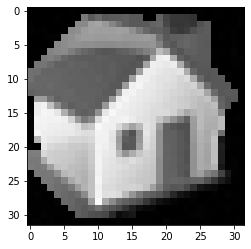

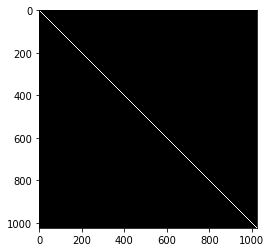

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [4]:
# test the above methods on the identity masking matrix
%matplotlib inline

## get the img
path = "Home.png"
img_matrix = img_to_gray_matrix(path)

height, width = get_img_dim(img_matrix)
H_identity = gen_identity_H(height, width) ## generate masking matrix

display_mask(img_matrix, 'gray')

display_mask(H_identity, 'bw') ## there are 1's in this matrix -- print to see (it's just difficult to display b/c they are 1 pixel each)

print(H_identity)

<IPython.core.display.Javascript object>


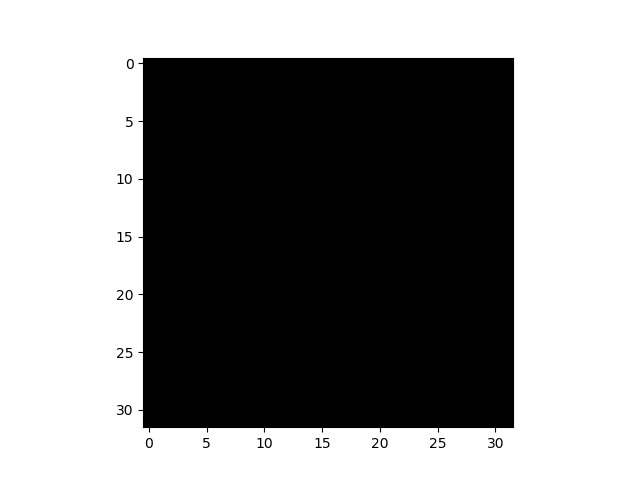

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [6]:
%matplotlib notebook

all_mask_results, _ = intermediate_mask_results(height, width, H_identity, img_matrix)

display_mask_results(all_mask_results)

<IPython.core.display.Javascript object>


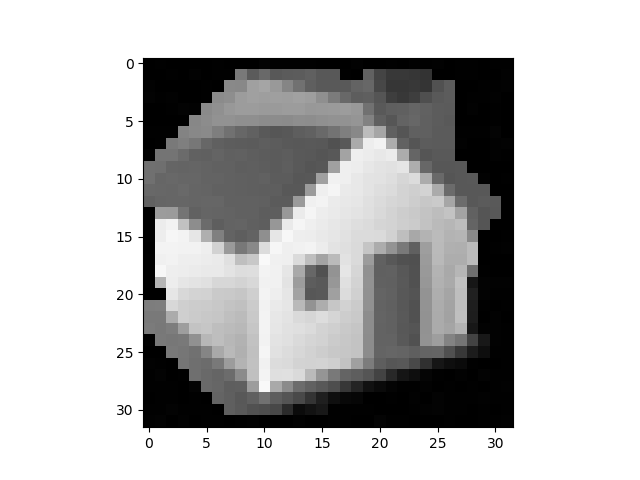

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [7]:
%matplotlib notebook

cum_mask_results = cumulative_mask_results(all_mask_results)

display_mask_results(cum_mask_results)

### Random Masking Matrix

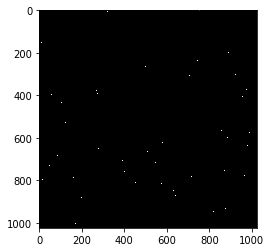

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(array([   0,    1,    2, ..., 1021, 1022, 1023], dtype=int64), array([722, 200, 753, ..., 179, 100,  71], dtype=int64))


In [7]:
# test the above methods on a randomly-generated masking matrix
%matplotlib inline

## get the img
path = "Home.png"
img_matrix = img_to_gray_matrix(path)

height, width = get_img_dim(img_matrix)
H_random = gen_random_H_single(height, width) ## generate masking matrix

display_mask(H_random, 'bw') ## there are 1's in this matrix -- print to see (it's just difficult to display b/c they are 1 pixel each)

print(H_random)

print(np.nonzero(H_random)) # the first element returned is the list of height 'coordinates' (row #'s), the second is the list of width 'coordinates'

In [22]:
%matplotlib notebook

all_mask_results, _ = intermediate_mask_results(height, width, H_random, img_matrix)

display_mask_results(all_mask_results)

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


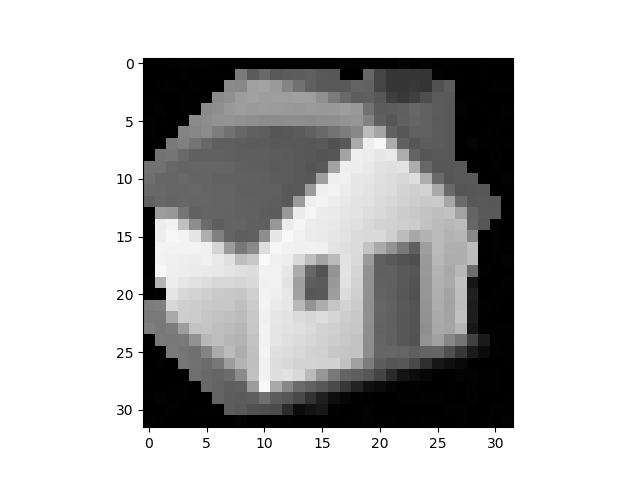

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [23]:
%matplotlib notebook

cum_mask_results = cumulative_mask_results(all_mask_results)

display_mask_results(cum_mask_results)

### H-Alt Masking Matrix

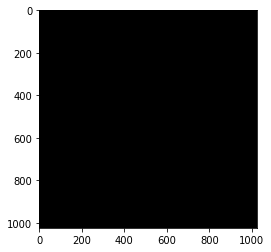

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(array([   0,    1,    2, ..., 1021, 1022, 1023], dtype=int64), array([   0,    2,    4, ..., 1019, 1021, 1023], dtype=int64))


In [10]:
# test the above methods on the H Alt masking matrix
%matplotlib inline

## get the img
path = "Home.png"
img_matrix = img_to_gray_matrix(path)

height, width = get_img_dim(img_matrix)
H_Alt = gen_H_Alt(height, width) ## generate masking matrix

display_mask(H_Alt, 'bw') ## there are 1's in this matrix -- print to see (it's just difficult to display b/c they are 1 pixel each)

print(H_Alt)

print(np.nonzero(H_Alt)) # the first element returned is the list of height 'coordinates' (row #'s), the second is the list of width 'coordinates'

<IPython.core.display.Javascript object>


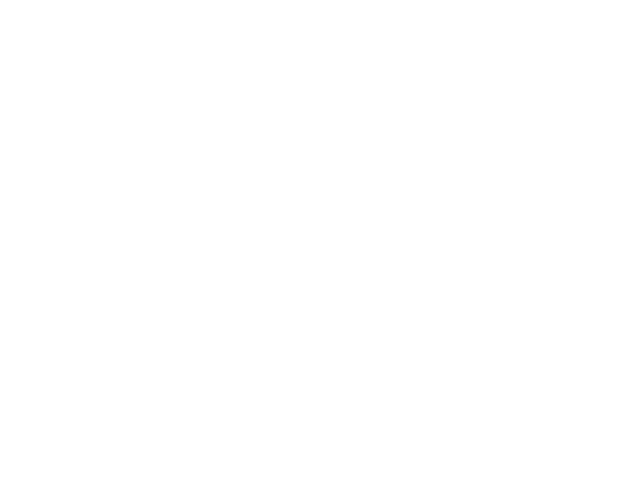

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [11]:
%matplotlib notebook

all_mask_results, _ = intermediate_mask_results(height, width, H_Alt, img_matrix)

display_mask_results(all_mask_results)

<IPython.core.display.Javascript object>


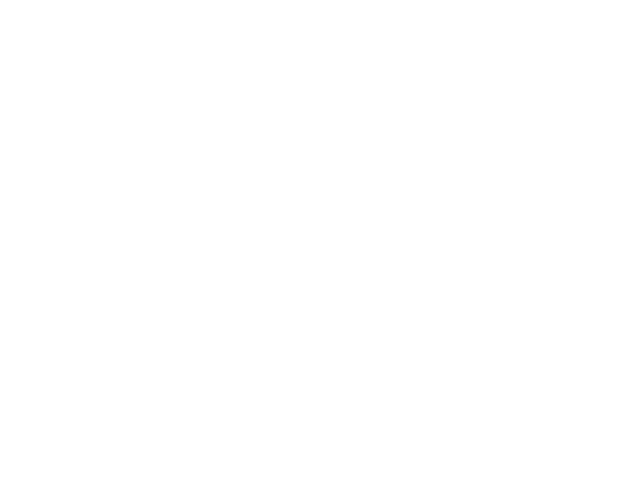

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [12]:
%matplotlib notebook

cum_mask_results = cumulative_mask_results(all_mask_results)

display_mask_results(cum_mask_results)

## Multi-Pixel Imaging

In [13]:
# these functions could go in a helper.py file

def gen_random_H_multiple(height, width):
    dim = height * width
    unshaped_H = np.round(np.random.rand(dim * dim), 0)
    return np.reshape(unshaped_H, (dim, dim))
    
def gen_mystery_H(height, width):
    dim = height * width
    if int(np.math.log(dim, 2)) != np.math.log(dim, 2):
        raise ValueError("The number of pixels in the image must be a power of 2.")
    mystery_H = hadamard(dim)
    mystery_H[mystery_H == -1] = 0
    return mystery_H

### Random Masking Matrix

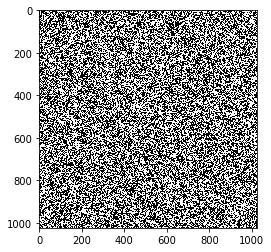

[[0. 1. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]]
(array([   0,    0,    0, ..., 1023, 1023, 1023], dtype=int64), array([   1,    3,    5, ..., 1019, 1020, 1023], dtype=int64))


In [14]:
# test the above methods on a randomly-generated *multi-pixel* masking matrix
%matplotlib inline

## get the img
path = "Home.png"
img_matrix = img_to_gray_matrix(path)

height, width = get_img_dim(img_matrix)
H_random_multiple = gen_random_H_multiple(height, width) # generate masking matrix

display_mask(H_random_multiple, 'bw') # there are 1's in this matrix -- print to see (it's just difficult to display b/c they are 1 pixel each)

print(H_random_multiple)

print(np.nonzero(H_random_multiple)) # the first element returned is the list of height 'coordinates' (row #'s), the second is the list of width 'coordinates'

<IPython.core.display.Javascript object>


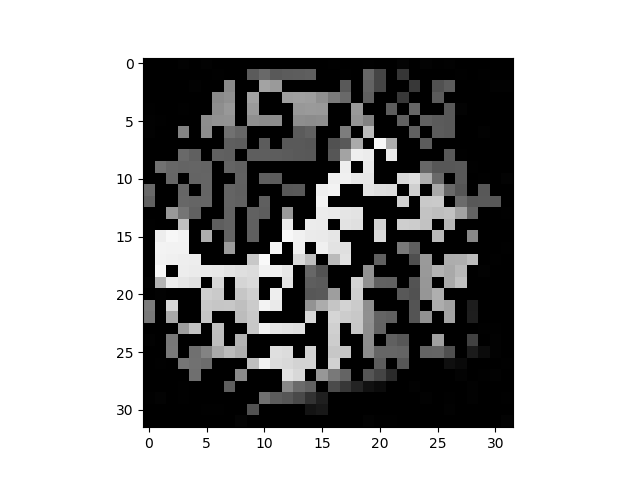

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [24]:
%matplotlib notebook

all_mask_results, _ = intermediate_mask_results(height, width, H_random_multiple, img_matrix)

display_mask_results(all_mask_results)

<IPython.core.display.Javascript object>


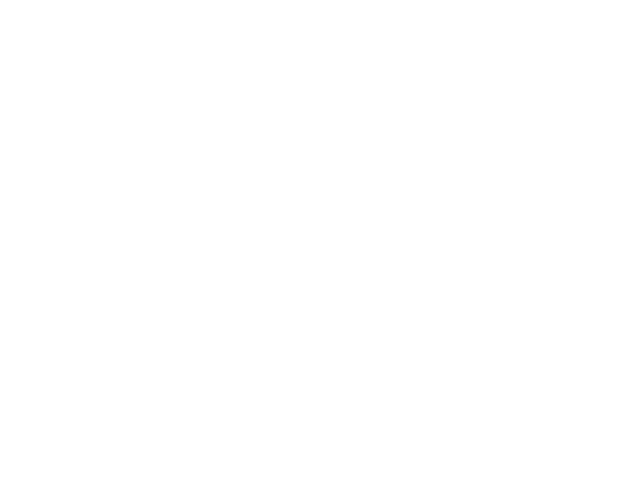

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [25]:
%matplotlib notebook

cum_mask_results = cumulative_mask_results(all_mask_results, 1)

display_mask_results(cum_mask_results)

### Mystery Masking Matrix (Hadamard)

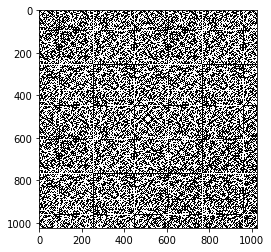

[[1 1 1 ... 1 1 1]
 [1 0 1 ... 0 1 0]
 [1 1 0 ... 1 0 0]
 ...
 [1 0 1 ... 0 1 0]
 [1 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 1]]
(array([   0,    0,    0, ..., 1023, 1023, 1023], dtype=int64), array([   0,    1,    2, ..., 1018, 1020, 1023], dtype=int64))


In [17]:
# test the above methods on the mystery (Hadamard) matrix
%matplotlib inline

## get the img
path = "Home.png"
img_matrix = img_to_gray_matrix(path)

height, width = get_img_dim(img_matrix)
H_mystery = gen_mystery_H(height, width) # generate masking matrix

display_mask(H_mystery, 'bw') # there are 1's in this matrix -- print to see (it's just difficult to display b/c they are 1 pixel each)

print(H_mystery)

print(np.nonzero(H_mystery)) # the first element returned is the list of height 'coordinates' (row #'s), the second is the list of width 'coordinates'

In [26]:
%matplotlib notebook

all_mask_results, _ = intermediate_mask_results(height, width, H_mystery, img_matrix)

display_mask_results(all_mask_results)

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


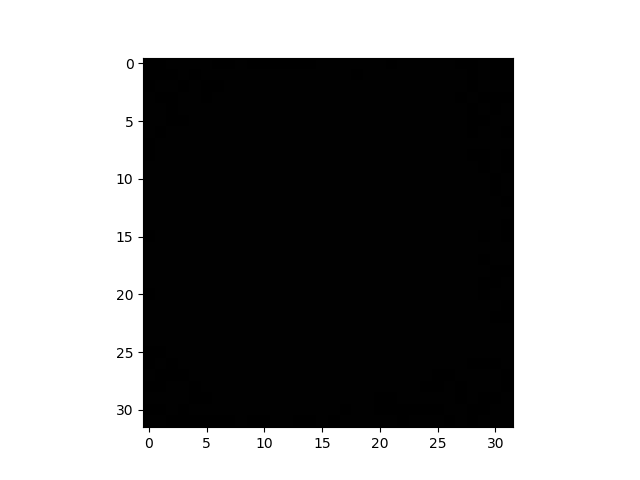

interactive(children=(IntSlider(value=0, description='mask', max=1023), Output()), _dom_classes=('widget-inter…

In [27]:
%matplotlib notebook

cum_mask_results = cumulative_mask_results(all_mask_results, 1)

display_mask_results(cum_mask_results)